# Predicting Credit Returns – An Asset Allocator’s Perspective

The corresponding medium article can be found by following the link below:

https://medium.com/@pranav.k.aggarwal/strategies-for-investing-in-corporate-bonds-part-i-92d8ab4de664

The github repository can be found by following the link below:
https://github.com/statarb1/CreditOAS.git


## Abstract

Timing entry into different asset classes is the fundamental problem in tactical asset allocation. Investment grade and high yield bonds form a significant asset class with a particularly strong value anchor which makes timing the asset class a fruitful exercise. 

This article explores using the option adjusted spread (OAS) on credit indices as a timing signal into the asset class and as a predictor for future returns for both IG and HY indices.

## Introduction
The option adjusted spread (OAS) for a fixed income security measures the spread (or yield difference) between the fixed income security and the risk free yield, adjusted for any embedded options. Simply put – the OAS is the yield of the fixed income security above that of the equivalent risk free government bond, adjusted for any embedded optionality. This is the compensation that the bond holder gets for providing capital to the ‘credit-risky’ bond issuer compared to providing capital to the ‘risk-free’ government bond.

In [25]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import os
from scipy.stats.stats import pearsonr
from zscore import zscore
from returns_analysis import returns_analysis

## Reading In Data

The following data is read from text files: 

1. Option adjusted spread (df_full_OAS and df_OAS)
2. Asset returns (labelled df_excess_ret)
3. Marketcap of each of the underlying indices (df_full_MV)

In [40]:
endDt = pd.to_datetime('20200612', format='%Y%m%d')
stDt = pd.to_datetime('20000101', format='%Y%m%d')

# Read in Data
df_excess_ret = pd.read_csv(r'creditData_excess_ret.txt', sep = ' ')
df_excess_ret.columns = df_excess_ret.columns.str.replace('\t' , '')
df_excess_ret['dates'] = pd.to_datetime(df_excess_ret['dates'])
df_excess_ret = df_excess_ret.loc[(df_excess_ret['dates'] > stDt) & (df_excess_ret['dates']<= endDt)]
df_excess_ret.set_index('dates', inplace=True)
df_excess_ret = df_excess_ret.astype('float64')
df_excess_ret.info()

df_full_OAS = pd.read_csv(r'creditData_full_OAS.txt', sep = ' ', skiprows=range(1))
df_full_OAS.columns = df_full_OAS.columns.str.replace("\t","")
df_full_OAS['dates'] = pd.to_datetime(df_full_OAS['dates'])
df_full_OAS = df_full_OAS.loc[(df_full_OAS['dates'] > stDt) & (df_full_OAS['dates']<= endDt)]
df_full_OAS.set_index('dates', inplace=True)
df_full_OAS = df_full_OAS.astype('float64')
df_full_OAS.info()

df_OAS = pd.read_csv(r'creditData_OAS.txt', sep = '\s+', skiprows=range(1))
df_OAS.columns = df_OAS.columns.str.replace("\t","")
df_OAS['dates'] = pd.to_datetime(df_OAS['dates'])
df_OAS = df_OAS.loc[(df_OAS['dates'] > stDt) & (df_OAS['dates']<= endDt)]
df_OAS.set_index('dates', inplace=True)
df_OAS = df_OAS.astype('float64')
df_OAS.info()

df_full_MV = pd.read_csv(r'creditData_full_MV.txt', sep = ' ', skiprows=range(1))
df_full_MV.columns = df_full_MV.columns.str.replace("\t","")
df_full_MV['dates'] = pd.to_datetime(df_full_MV['dates'])
df_full_MV = df_full_MV.loc[(df_full_MV['dates'] > stDt) & (df_full_MV['dates']<= endDt)]
df_full_MV.set_index('dates', inplace=True)
df_full_MV = df_full_MV.astype('float64')
df_full_MV.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1067 entries, 2000-01-07 to 2020-06-12
Data columns (total 10 columns):
IGWDAll          1067 non-null float64
IGUSDAll         1067 non-null float64
IGGBPAll         1067 non-null float64
IGEURAll         1067 non-null float64
IGShortUSDAll    1063 non-null float64
IGShortGBPAll    733 non-null float64
IGShortEURAll    1063 non-null float64
HYWDAll          1067 non-null float64
HYUSDAll         1067 non-null float64
HYEURAll         1067 non-null float64
dtypes: float64(10)
memory usage: 91.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1067 entries, 2000-01-07 to 2020-06-12
Data columns (total 40 columns):
IGWDAAA          1067 non-null float64
IGWDAA           1067 non-null float64
IGWDA            1067 non-null float64
IGWDBBB          1067 non-null float64
IGUSDAAA         1067 non-null float64
IGUSDAA          1067 non-null float64
IGUSDA           1067 non-null float64
IGUSDBBB         1067 non-null float64
IGGBPAA

## Plotting Data
Looking at the option adjusted spread on Global Investment Grade and Global High Yield bond indices in Figures 1 and 2 respectively, we can clearly see that these are not constant through time as market and default risks and investor sentiment evolve. 


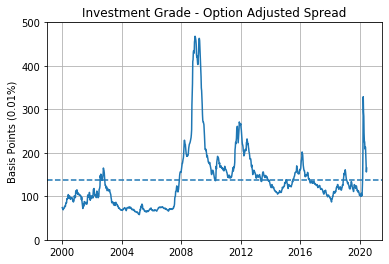

In [41]:
plt.plot(df_OAS['IGWDAll'])
plt.title('Investment Grade - Option Adjusted Spread')
plt.grid()
plt.ylabel('Basis Points (0.01%)')
plt.ylim([0, 500])
plt.axhline(np.mean(df_OAS['IGWDAll']),linestyle="dashed",linewidth= 1.5)


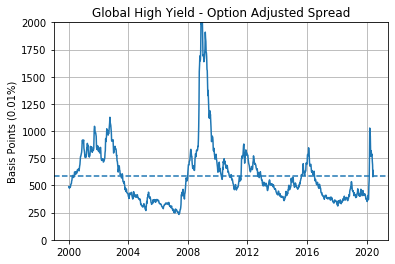

In [42]:
plt.plot(df_OAS['HYWDAll'])
plt.title('Global High Yield - Option Adjusted Spread')
plt.grid()
plt.ylabel('Basis Points (0.01%)')
plt.ylim([0, 2000])
plt.axhline(np.mean(df_OAS['HYWDAll']),linestyle="dashed",linewidth= 1.5)


Part of the reason for the drift in the OAS over time is the changing composition of the index. Credit rating agencies assign a credit rating to each issuer. Credit ratings are a discrete measure of the credit risk in a bond.  There are three main credit ratings agencies and there is generally a high degree of correlation between the ratings assigned by each to any given issuer. We will be using the credit ratings by S&P. Table 1 shows the credit ratings used by S&P. Bonds rated AAA to BBB are considered Investment Grade (IG) while bonds rated BB downwards are considered High Yield (HY) or ‘junk’ bonds. 

This table of credit rating and a descriptor of what this means is given below in table 1

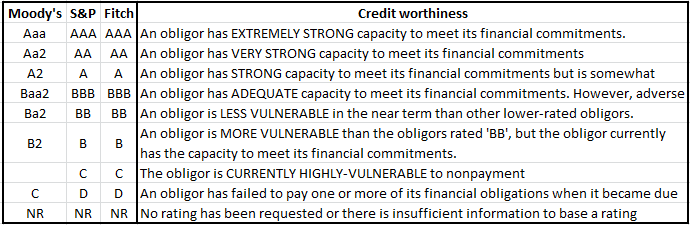

Table 1: Credit Ratings

## Calculating the Drift in Credit Quality and the Quality Adjusted OAS

Below we look at what the drift in credit quality has been for each index and calculate what the OAS would have been historically for each index if the credit quality was constant (fixed at today's credit quality)


In [43]:
colNames = [col for col in df_full_MV.columns if 'IGWD' in col]
WDIGIndicesMV = df_full_MV[colNames]
WDIGIndicesCurrentComposition=WDIGIndicesMV.iloc[-1,:].divide(WDIGIndicesMV.iloc[-1,:].sum(),axis=0)
WDIGIndicesComposition = WDIGIndicesMV.divide(WDIGIndicesMV.sum(axis=1),axis=0)
WDIGIndicesOAS = df_full_OAS[colNames]
WDIGCompositionAdjustedOAS = pd.DataFrame(np.sum(WDIGIndicesOAS*WDIGIndicesCurrentComposition,1), columns = ['IGWDAll'])

colNames = [col for col in df_full_MV.columns if 'IGUSD' in col]
USDIGIndicesMV = df_full_MV[colNames]
USDIGIndicesCurrentComposition=USDIGIndicesMV.iloc[-1,:].divide(USDIGIndicesMV.iloc[-1,:].sum(),axis=0)
USDIGIndicesComposition = USDIGIndicesMV.divide(USDIGIndicesMV.sum(axis=1),axis=0)
USDIGIndicesOAS = df_full_OAS[colNames]
USDIGCompositionAdjustedOAS = pd.DataFrame(np.sum(USDIGIndicesOAS*USDIGIndicesCurrentComposition,1), columns = ['IGUSDAll'])

colNames = [col for col in df_full_MV.columns if 'IGEUR' in col]
EURIGIndicesMV = df_full_MV[colNames]
EURIGIndicesCurrentComposition=EURIGIndicesMV.iloc[-1,:].divide(EURIGIndicesMV.iloc[-1,:].sum(),axis=0)
EURIGIndicesComposition = EURIGIndicesMV.divide(EURIGIndicesMV.sum(axis=1),axis=0)
EURIGIndicesOAS = df_full_OAS[colNames]
EURIGCompositionAdjustedOAS = pd.DataFrame(np.sum(EURIGIndicesOAS*EURIGIndicesCurrentComposition,1), columns = ['IGEURAll'])

colNames = [col for col in df_full_MV.columns if 'IGGBP' in col]
GBPIGIndicesMV = df_full_MV[colNames]
GBPIGIndicesCurrentComposition=GBPIGIndicesMV.iloc[-1,:].divide(GBPIGIndicesMV.iloc[-1,:].sum(),axis=0)
GBPIGIndicesComposition = GBPIGIndicesMV.divide(GBPIGIndicesMV.sum(axis=1),axis=0)
GBPIGIndicesOAS = df_full_OAS[colNames]
GBPIGCompositionAdjustedOAS = pd.DataFrame(np.sum(GBPIGIndicesOAS*GBPIGIndicesCurrentComposition,1), columns = ['IGGBPAll'])

colNames = [col for col in df_full_MV.columns if 'IGShortUSD' in col]
USDIGShortIndicesMV = df_full_MV[colNames]
USDIGShortIndicesCurrentComposition=USDIGShortIndicesMV.iloc[-1,:].divide(USDIGShortIndicesMV.iloc[-1,:].sum(),axis=0)
USDIGShortIndicesComposition = USDIGShortIndicesMV.divide(USDIGShortIndicesMV.sum(axis=1),axis=0)
USDIGShortIndicesOAS = df_full_OAS[colNames]
USDIGShortCompositionAdjustedOAS = pd.DataFrame(np.sum(USDIGShortIndicesOAS*USDIGShortIndicesCurrentComposition,1), columns = ['IGShortUSD'])

colNames = [col for col in df_full_MV.columns if 'IGShortEUR' in col]
EURIGShortIndicesMV = df_full_MV[colNames]
EURIGShortIndicesCurrentComposition=EURIGShortIndicesMV.iloc[-1,:].divide(EURIGShortIndicesMV.iloc[-1,:].sum(),axis=0)
EURIGShortIndicesComposition = EURIGShortIndicesMV.divide(EURIGShortIndicesMV.sum(axis=1),axis=0)
EURIGShortIndicesOAS = df_full_OAS[colNames]
EURIGShortCompositionAdjustedOAS = pd.DataFrame(np.sum(EURIGShortIndicesOAS*EURIGShortIndicesCurrentComposition,1), columns = ['IGShortEUR'])

colNames = [col for col in df_full_MV.columns if 'IGShortGBP' in col]
GBPIGShortIndicesMV = df_full_MV[colNames]
GBPIGShortIndicesCurrentComposition = GBPIGShortIndicesMV.iloc[-1,:].divide(GBPIGShortIndicesMV.iloc[-1,:].sum(),axis=0)
GBPIGShortIndicesComposition = GBPIGShortIndicesMV.divide(GBPIGShortIndicesMV.sum(axis=1),axis=0)
GBPIGShortIndicesOAS = df_full_OAS[colNames]
GBPIGShortCompositionAdjustedOAS = pd.DataFrame(np.sum(GBPIGShortIndicesOAS*GBPIGShortIndicesCurrentComposition,1), columns = ['IGShortGBP'])

colNames = [col for col in df_full_MV.columns if 'HYWD' in col]
WDHYIndicesMV = df_full_MV[colNames]
WDHYIndicesCurrentComposition=WDHYIndicesMV.iloc[-1,:].divide(WDHYIndicesMV.iloc[-1,:].sum(),axis=0)
WDHYIndicesComposition = WDHYIndicesMV.divide(WDHYIndicesMV.sum(axis=1),axis=0)
WDHYIndicesOAS = df_full_OAS[colNames]
WDHYCompositionAdjustedOAS = pd.DataFrame(np.sum(WDHYIndicesOAS*WDHYIndicesCurrentComposition,1), columns = ['HYWDAll'])

colNames = [col for col in df_full_MV.columns if 'HYUSD' in col]
USDHYIndicesMV = df_full_MV[colNames]
USDHYIndicesCurrentComposition=USDHYIndicesMV.iloc[-1,:].divide(USDHYIndicesMV.iloc[-1,:].sum(),axis=0)
USDHYIndicesComposition = USDHYIndicesMV.divide(WDHYIndicesMV.sum(axis=1),axis=0)
USDHYIndicesOAS = df_full_OAS[colNames]
USDHYCompositionAdjustedOAS = pd.DataFrame(np.sum(USDHYIndicesOAS*USDHYIndicesCurrentComposition,1), columns = ['HYUSDAll'])

colNames = [col for col in df_full_MV.columns if 'HYEUR' in col]
EURHYIndicesMV = df_full_MV[colNames]
EURHYIndicesCurrentComposition=EURHYIndicesMV.iloc[-1,:].divide(EURHYIndicesMV.iloc[-1,:].sum(),axis=0)
EURHYIndicesComposition = EURHYIndicesMV.divide(EURHYIndicesMV.sum(axis=1),axis=0)
EURHYIndicesOAS = df_full_OAS[colNames]
EURHYCompositionAdjustedOAS = pd.DataFrame(np.sum(EURHYIndicesOAS*EURHYIndicesCurrentComposition,1), columns = ['HYEURAll'])



In [44]:
OASCompAdjOAS = pd.concat([WDIGCompositionAdjustedOAS, USDIGCompositionAdjustedOAS,
                 GBPIGCompositionAdjustedOAS, EURIGCompositionAdjustedOAS, 
                 USDIGShortCompositionAdjustedOAS, GBPIGShortCompositionAdjustedOAS, EURIGShortCompositionAdjustedOAS,
                 WDHYCompositionAdjustedOAS, USDHYCompositionAdjustedOAS, EURHYCompositionAdjustedOAS], axis = 1, sort = False)


Figures below show how the composition of the Global IG and Global HY indices has changed from a credit ratings lens. There has been significant shift in the average credit rating of bonds in each index. The IG index has a much higher proportion of BBB and A bonds now than it did historically – the average credit rating for the IG index is much worse now than in the early 2000’s. 
For the HY index – the opposite is true. The credit rating of the average bond in the HY universe is better now than it was in the early 2000’s.


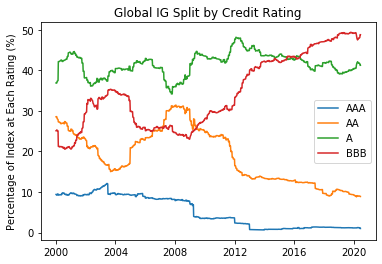

In [45]:
plt.plot(WDIGIndicesComposition*100)
plt.title('Global IG Split by Credit Rating')
#plt.legend(WDIGIndicesCurrentComposition.columns)
plt.legend(('AAA','AA','A','BBB'))
plt.ylabel('Percentage of Index at Each Rating (%)')
plt.show()

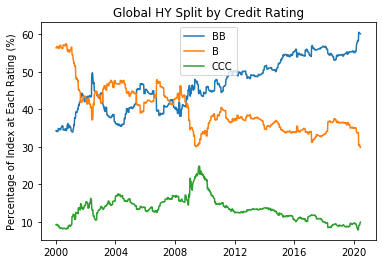

In [46]:
plt.plot(WDHYIndicesComposition*100)
plt.title('Global HY Split by Credit Rating')
#plt.legend(WDHYIndicesCurrentComposition.columns)
plt.legend(('BB','B','CCC'))
plt.ylabel('Percentage of Index at Each Rating (%)')
plt.show()

Assuming the objectivity of the credit ratings agencies has not changed over time, i.e. assuming a company with the same characteristics would have been rated the same in the year 2000 as now – we can calculate what the ‘drift adjusted’ OAS should be. Here we are correcting for the changing composition of the index by fixing the index composition at today’s composition and backing out the index OAS given today’s composition. It is worth mentioning that the assumption on the constant objectivity of credit ratings agencies through time is not a trivial one and can be investigated, though that is a debate for another article. 

This ratings drift adjusted OAS for both Global IG and Global HY indices is shows in figures below along with the unadjusted OAS for each market. As can be seen the adjustment is significant. 

Text(0.5, 1.0, 'Global Investment Grade')

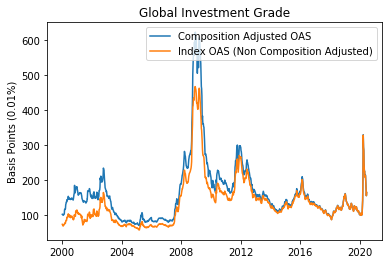

In [48]:
plt.plot(WDIGCompositionAdjustedOAS)
plt.plot(df_OAS['IGWDAll'])
plt.ylabel('Basis Points (0.01%)')
plt.legend(('Composition Adjusted OAS','Index OAS (Non Composition Adjusted)'))
plt.title('Global Investment Grade')

Figure 5 – Composition adjusted OAS for Global IG index assuming today’s composition. If the IG index had today’s composition, the OAS would have been much higher historically (blue line)

Text(0.5, 1.0, 'Global High Yield')

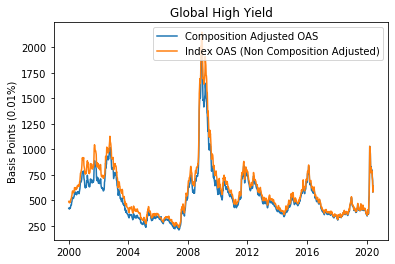

In [49]:
plt.plot(WDHYCompositionAdjustedOAS)
plt.plot(df_OAS['HYWDAll'])
plt.ylabel('Basis Points (0.01%)')
plt.legend(('Composition Adjusted OAS','Index OAS (Non Composition Adjusted)'))
plt.title('Global High Yield')


Figure 6 – Composition adjusted OAS for Global HY index assuming today’s composition. If the HY index had today’s composition, the OAS would have been lower historically (blue line)

This adjustment brings the data exploration and wrangling to a close. Now we turn to the main question we are looking to answer - Can the Option Adjusted Spread for an index predict the future returns for that index?

## Can the Option Adjusted Spread for an index predict the future returns for that index?

The first test comes from looking at the scatter plot of starting OAS and the subsequent period excess returns over the equivalent maturity government bond. Below looks at the starting IG index OAS and subsequent period returns where the period length is 13 weeks, 26 weeks and 52 weeks respectively. There is a clear positive correlation between the two, and indeed the correlation is much stronger than one find generally in financial markets. 

In [50]:
df_excess_ret_index = df_excess_ret.copy()
df_excess_ret_index += 1
df_excess_ret_index = df_excess_ret_index.cumprod(axis = 'index', skipna = True)


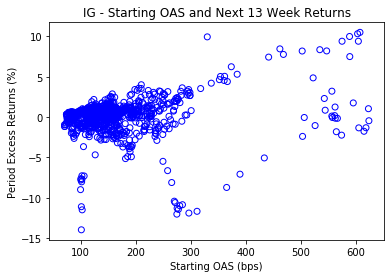

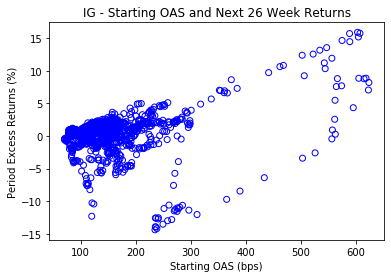

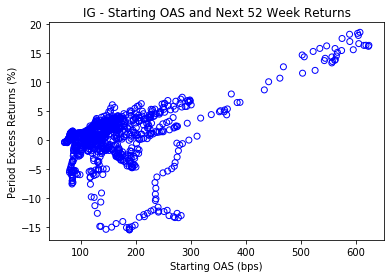

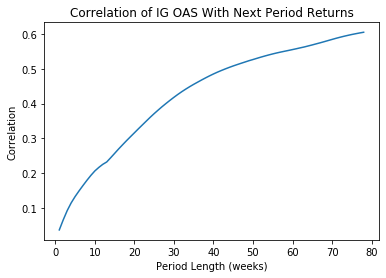

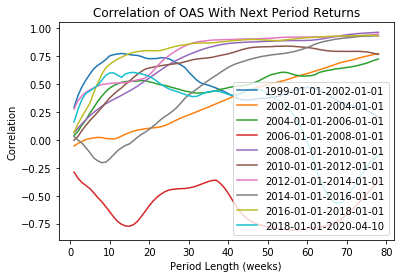

In [51]:
asset_class = 'IGWDAll'
OAS, score, cum_ret, corr_full, corr = returns_analysis(OASCompAdjOAS, df_excess_ret_index, asset_class)


The same analysis for HY is shown below:

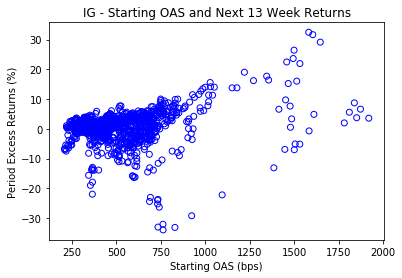

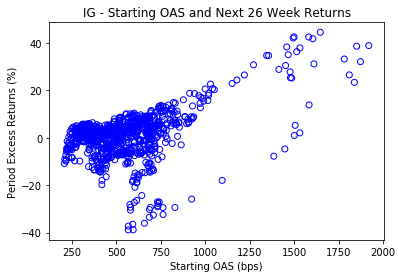

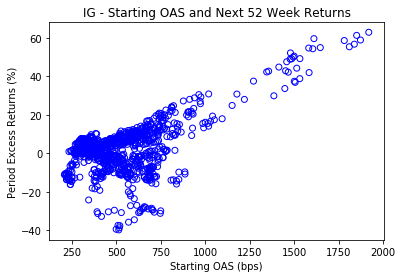

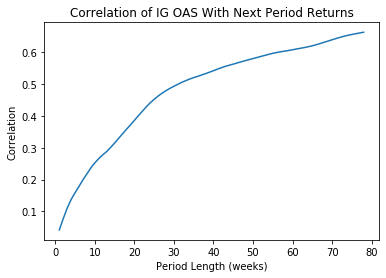

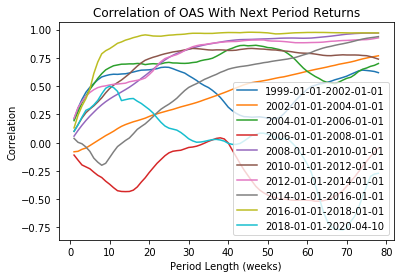

In [52]:
asset_class = 'HYWDAll'
OAS, score, cum_ret, corr_full, corr = returns_analysis(OASCompAdjOAS, df_excess_ret_index, asset_class)


## Rationalising the positive correlation between starting spreads and subsequent returns

The return for a buy and hold investor in a bond is:

Excess Ret = OAS + Change in value due to changes in OAS – default & downgrading losses

In the absence of any further movement on the OAS, unless the default and downgrading losses go up one for one with OAS, the income due to higher yield is going to push subsequent period returns higher. This is the income component. 

Secondly, the change in OAS for Global IG and Global HY is negatively correlated to the starting value of OAS. Essentially, if starting OAS is high, the correlation implies that the OAS is likely to revert towards the mean. This is the capital appreciation component. This mean reversion in spreads adds to the higher income component at times when OAS is high leading to an outperformance. 


## Correlation Strength and Holding Periods

The correlation appears to get stronger the longer the holding period. The correlation between stating OAS and subsequent period excess return is explored over a range of period length ranging from 1 week to 78 weeks for both Global IG and Global HY. The results can be seen in the fourth figures produced by the function results_analysis above for IG and HY. There appears to be a clear monotonic relationship between the holding period and the correlation between starting OAS for both IG and HY. Another thing to note is the slightly higher correlation for HY compared to IG. It must be noted however that both sets of correlations are very high compared to other models generally available in most financial markets. 

The higher correlation can be interpreted as reduced uncertainty in the outcome. This reduced uncertainty in outcome at longer holding periods is because spreads need time to mean revert. In fact, spreads are positively serially correlated over shorter time periods and are mean reverting over longer time periods. This phenomenon directly contributes to the stronger correlation we see at higher holding periods. 


**Breaking Down the Results Across Periods**
This monotonic relationship, though great on average from Jan 2000 to June 2020, does not exist for all periods. The final figures output by the function 'returns_analysis' show the correlation charts broken down by different periods for IG and HY respectively. The trends are very similar to the one observed for the full dataset in Fig 9. However, periods, particularly the period spanning Jan 2006 to Jan 2008 shows a very different result. The correlation between spreads and forward looking returns was very negative in this period due to the continued sell-off in corporate bonds for over 2 years.

## Intuitive Explanations to the Above Results

What should be clear from the above analysis is that option adjusted spreads are a great predictor for future return for corporate bonds (both investment grade and high yield bonds). 

The obvious question to ask is – why does it work? If one subscribes fully to the efficient market hypothesis – such opportunities should not be possible. There are specific reasons why it is possible to exploit this phenomenon. 

Credit spreads (OAS) widen and bonds sell off at times of economic and financial market stress when investor risk aversion is rising. Further, for a risk neutral investor, OAS is compensation for defaults and downgrade losses, both of which rise during periods of market stress. Hence some of the widening in credit spreads is justified due to higher losses in the shape of higher defaults and downgrades, even for risk neutral investors. For risk averse investors, demanding higher compensation than that strictly required to cover the increased losses for downgrades and defaults in the form of wider credit spreads is also natural. The above rational investor behaviour combined with the irrational market overreaction leads to an opportunity at times of market stress which can be rewarding for investors with suitably long investment horizons. 

The above would be true generally for equities along with for corporate bonds. However, it is important to note that the predictive power of OAS in corporate bonds is higher than for valuation based indicators in other asset classes like equities — simply because of the more mean-reverting nature of spreads which give corporate bonds a stronger valuation anchor. 

## Conclusion
The analysis in this paper discussed the evolving nature of credit spreads and also changing composition of credit indices. The analysis demonstrated that option adjusted spreads are a great predictor for future return for corporate bonds (both investment grade and high yield bonds). 
Devising a trading strategy around OAS is clearly possible. A simple approach would be to use z-scores or percentiles whereby the investor compares the OAS of the bond index now vs historical values. Higher z-scores or percentile values would lead to a buy signal and vice -versa.
As with most valuation models — combining this strategy with a trend model would be beneficial from a correlation perspective — ultimately achieving higher Information Ratios and lower drawdowns. We will be discussing trend models in another part of the ‘Strategies for Investing in Corporate Bonds’ series.
